In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
import sentencepiece as spm

from cnlp.fastai_extended import LanguageModelLoader, LanguageModelData

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_unigram.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
# Set shuffle = False to keep sentences from the same paragraph together
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, shuffle=False)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, shuffle=False)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 0) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 82818072
Unknown Percentage: 0.89 %


In [20]:
bptt = 200
batch_size = 128
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = LanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt, target_length=160, batch_first=True)
val_loader = LanguageModelLoader(
    np.concatenate(val_tokens), batch_size, bptt, target_length=160, batch_first=True)
tst_loader = LanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt, target_length=160, batch_first=True)

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/unigram_model.model")

True

In [10]:
np.sum([np.sum(x == 2) for x in tokens]) # </s>

0

In [11]:
sp.DecodeIds(trn_tokens[0].tolist())

'每当 有 涉及 数量 、 结构 、 空间 及 变化 等 方面 的 困难 问题 时 , 通常 就 需要 用 到 数学 工具 去 解决 问题 , 而 这 往往 也 拓展 了 数学 的 研究 范畴 。'

In [12]:
path = Path("../data/cache/lm_unigram_transformer/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

In [13]:
n_tok

7500

### Transformer Model

In [13]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

In [14]:
# Courtesy of https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in learner.model.parameters())
pytorch_trainable_params = sum(p.numel() for p in learner.model.parameters() if p.requires_grad)
pytorch_total_params, pytorch_trainable_params

(6820400, 6820400)

In [36]:
learner = model_data.get_transformer_model(
    partial(Adam, betas=(0.9, 0.999)),
    max_seq_len=trn_loader.max_possible_seq_len,
    emb_sz=300,
    n_head=12,
    n_layer=3,
    embd_pdrop=0.05,
    attn_pdrop=0.1,
    resid_pdrop=0.1
)

In [37]:
pytorch_total_params = sum(p.numel() for p in learner.model.parameters())
pytorch_trainable_params = sum(p.numel() for p in learner.model.parameters() if p.requires_grad)
pytorch_total_params, pytorch_trainable_params

(7811700, 7811700)

epoch      trn_loss   val_loss                                  
    0      7.340826   7.30481   
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 32.3 ms


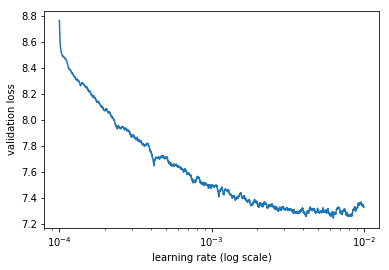

In [38]:
learner.clip = 10.
learner.lr_find(start_lr=1e-4, end_lr=1e-2, linear=False)
%time learner.sched.plot()

In [39]:
lrs = 2e-3
learner.clip = 20.
%time learner.fit(lrs, 1, wds=0, use_clr=(50, 4), cycle_len=10, use_wd_sched=False)

epoch      trn_loss   val_loss                                  
    0      7.125738   7.081796  
    1      6.521563   6.370249                                  
    2      6.389347   6.218776                                  
    3      6.283103   6.115037                                  
    4      6.215028   6.036267                                  
    5      6.158033   5.977473                                  
    6      6.105417   5.933303                                  
    7      6.063311   5.888864                                  
    8      6.025327   5.852345                                  
    9      5.994187   5.819882                                  
CPU times: user 2h 42min 46s, sys: 2h 8min 13s, total: 4h 51min
Wall time: 4h 50min 50s


[5.819882451294016]

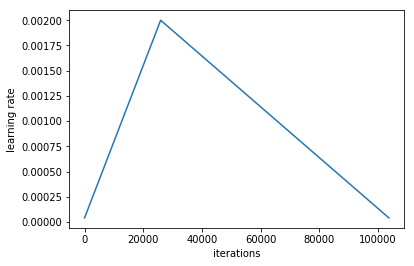

In [40]:
learner.sched.plot_lr()

In [41]:
learner.save("lm_transformer")
learner.save_encoder("lm_transformer_enc")

In [42]:
tmp_iter = iter(trn_loader)

In [43]:
next(tmp_iter)[0].shape

torch.Size([128, 200])

In [45]:
learner.load("lm_transformer")

## Test the model

In [46]:
learner.model.eval()

SequentialRNN(
  (0): TransformerEncoder(
    (embed): Embedding(7700, 300, padding_idx=2)
    (drop): Dropout(p=0.05)
    (blocks): ModuleList(
      (0): Block(
        (attn): Attention(
          (c_attn): Linear(in_features=300, out_features=900, bias=True)
          (c_proj): Linear(in_features=300, out_features=300, bias=True)
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln_1): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=300, out_features=1200, bias=True)
          (c_proj): Linear(in_features=1200, out_features=300, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (ln_2): LayerNorm()
      )
      (1): Block(
        (attn): Attention(
          (c_attn): Linear(in_features=300, out_features=900, bias=True)
          (c_proj): Linear(in_features=300, out_features=300, bias=True)
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): Dropout(p=0.1)
        )
        (ln

### Next Character Inference

In [47]:
tokens = sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计")
tokens

[513,
 11,
 314,
 29,
 95,
 45,
 14,
 4,
 51,
 1690,
 712,
 195,
 3,
 1156,
 34,
 354,
 2923,
 450,
 3523]

In [48]:
iterator = iter(tst_loader)
x, y = next(iterator)

In [49]:
x.shape, y.shape

(torch.Size([128, 200]), torch.Size([20480]))

In [50]:
logits = learner.model(x.to("cuda"))
logits.shape

torch.Size([20480, 7500])

In [51]:
def eval_tensors(x, y):
    logits = learner.model(x.to("cuda"))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    return pd.DataFrame({
        "orig": [sp.IdToPiece(int(i)) for i in x[0, 40:].numpy()] + [""], 
        "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2],
        "actual": [""] + [sp.IdToPiece(int(i)) for i in y.numpy()]
    })
tmp = eval_tensors(x[:1, :], y[:160])
tmp[:20]

,actual,orig,pred_1,pred_2,pred_3
0,,"▁,",,,
1,▁引,▁引,▁,▁而,▁并
2,致,致,致,述,▁物理
3,▁澳门,▁澳门,▁气象局,泽,▁
4,▁交通,▁交通,▁的,▁,▁政府
5,▁,▁,部,▁大学,局
6,<unk>,<unk>,枢,状况,邮
7,"▁,","▁,","▁,",▁,▁。
8,▁市民,▁市民,▁,▁以,▁而
9,▁要,▁要,▁,▁不,▁的


In [52]:
tmp.iloc[-20:]

,actual,orig,pred_1,pred_2,pred_3
141,录,录,▁上,▁中,▁的
142,▁得,▁得,▁的,▁中,▁上
143,▁飓风,▁飓风,▁,▁很,▁不
144,▁程度,▁程度,▁的,▁,"▁,"
145,▁10,▁10,▁上,"▁,",▁较
146,▁分钟,▁分钟,5,6,3
147,▁平均,▁平均,"▁,",▁后,▁内
148,▁风速,▁风速,▁风速,▁强度,▁气
149,"▁,","▁,",▁为,"▁,",▁
150,▁以及,▁以及,▁因此,▁所以,▁故


In [53]:
tmp = eval_tensors(x[1:2, :], y[160:320])
tmp[-20:]

,actual,orig,pred_1,pred_2,pred_3
141,▁联合,▁联合,▁而,▁并,▁但
142,▁台风,▁台风,围,艇,▁协定
143,▁警报,▁警报,▁警报,▁中心,▁
144,▁中心,▁中心,▁中心,品,▁基地
145,▁则,▁则,▁在,▁也,▁的
146,▁于,▁于,▁在,▁于,▁被
147,▁21,▁21,▁7,▁下午,▁9
148,号,号,时,日,号
149,▁的,▁的,▁及,▁之,▁以
150,▁上,▁上,▁,▁时候,▁过程


In [54]:
def eval_text(texts):
    tokens =sp.EncodeAsIds(texts)
    logits = learner.model(T(tokens).unsqueeze(0))
    print(logits.shape)
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    return pd.DataFrame({"orig": sp.EncodeAsPieces(texts)[-160:] + [""], 
                  "pred_1": [""] + preds[0][-160:], "pred_2": [""] + preds[1][-160:], "pred_3": [""] + preds[2][-160:]})

In [55]:
sp.DecodeIds(x[0, :].numpy().tolist())

'气象局 遭 指控 比 香港 「慢 半 拍 」 , 引致 气象局 公信力 下降 ; 同时 预警 时间 只 有 稍 多 于 1 小时 , 兼且 正值 下班 繁忙 时间 , 引致 澳门 交通  ⁇  , 市民 要 花 上 比 平常 多 3 倍 的 时间 才 能 回家 。 澳门 立法会 议员 林香生 批评 预报 不 及时 和 欠缺 人性化 , 并 建议 当局 把 预警 时间 延长 至 2 小时 或 以上 。 各 部门 的 危机 小组 亦 被 指责 各自为政 , 导致 应变 效率 低下 、 应急 机制 完全 失效 , 市内 多 处 竟然 没有 交通 警当值 , 无 人 指挥 交通 , 有 车辆 借机 逆线 行驶 , 情况 险象环生 。 由于 气象局 在 悬挂 九 号 风球 的 时间 上 严重 延误 , 加上 在 3 条 大桥 实测录 得 飓风 程度 10 分钟 平均 风速 , 以及 澳门 比 香港 更 接近 风暴 中心的 情况'

In [56]:
tmp = eval_text(sp.DecodeIds(x[6, :].numpy().tolist()))
tmp

torch.Size([160, 7500])


,orig,pred_1,pred_2,pred_3
0,▁目标,,,
1,"▁,","▁,",▁。,▁是
2,▁则,▁则,▁就,▁那么
3,▁整,▁可以,▁会,▁可
4,▁部,顿,▁条,整
5,▁列车,▁份,▁,珊
6,▁都,▁的,▁可以,▁在
7,▁要,▁会,▁可以,▁是
8,▁跟,▁射击,▁,藤
9,著,著,踪,▁


In [57]:
eval_text("特朗普 政府 以为 加征 关税 会 令 中国 屈服 ， 这种 策略 肯定 会 适得其反 ， 如果 就业 和 财富")

torch.Size([33, 7500])


,orig,pred_1,pred_2,pred_3
0,▁特,,,
1,朗,<unk>,▁舰,臣
2,普,<unk>,▁舰,臣
3,▁政府,<unk>,▁舰,臣
4,▁以为,<unk>,▁舰,臣
5,▁加,<unk>,▁舰,臣
6,征,<unk>,▁舰,臣
7,▁关,<unk>,▁舰,▁戏
8,税,<unk>,▁舰,▁戏
9,▁会,<unk>,▁舰,▁戏


In [58]:
eval_text("对 中国 与 南洋 发动 全面 的 战争 。 1990 年代 ， 中")

torch.Size([14, 7500])


,orig,pred_1,pred_2,pred_3
0,▁对,,,
1,▁中国,<unk>,▁舰,臣
2,▁与,<unk>,▁舰,臣
3,▁南,<unk>,▁舰,臣
4,洋,<unk>,▁舰,臣
5,▁发动,<unk>,▁舰,臣
6,▁全面,<unk>,▁舰,臣
7,▁的,<unk>,▁舰,▁戏
8,▁战争,<unk>,▁舰,▁戏
9,▁。,<unk>,▁舰,▁戏
